In [ ]:
!pip install tensorflow
! pip install shap
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)
import time
from tqdm import tqdm

2.17.0


In [ ]:
import shap
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
import imghdr


In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split # import the missing function


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



In [ ]:
# ! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

In [ ]:
# # prompt: open brain-tumor-mri-dataset.zip file

# ! unzip /content/brain-tumor-mri-dataset.zip


In [65]:
! kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
100% 149M/149M [00:09<00:00, 16.6MB/s]
100% 149M/149M [00:09<00:00, 15.9MB/s]


In [66]:
! unzip /content/the-iqothnccd-lung-cancer-dataset.zip

Archive:  /content/the-iqothnccd-lung-cancer-dataset.zip
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (102).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (105).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (106).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (107).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (108).jpg  
  inflating

In [ ]:
# Generate data paths with labels
train_data_dir = '/content/Training'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)



In [ ]:
train_df = None
valid_df = None
test_df = None

In [ ]:
train_Fseries = pd.Series(filepaths, name='filepaths')
train_Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([train_Fseries, train_Lseries], axis=1)

# Split the training data into 90% training and 10% testing
strat = train_df['labels']
train_df, valid_df = train_test_split(train_df, train_size=0.88, shuffle=True, random_state=123, stratify=strat)


In [ ]:
test_data_dir = '/content/Testing'
filepaths = []
labels = []

# Get folder names and their files
folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
test_Fseries = pd.Series(filepaths, name='filepaths')
test_Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([test_Fseries, test_Lseries], axis=1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input # Import directly from inception_v3 module

Found 5026 validated image filenames belonging to 4 classes.
Found 686 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


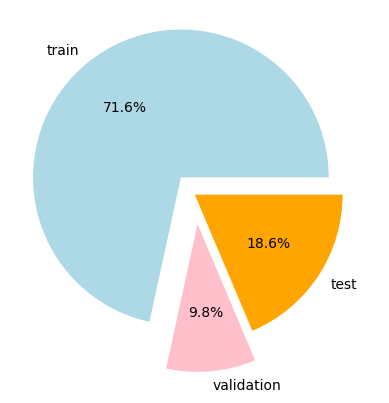

<Figure size 640x480 with 0 Axes>

In [ ]:
batch_size = 16
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Training data generator with augmentation
tr_gen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.2,
    zoom_range=0.09,
    width_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,  # Add vertical flip if applicable
    brightness_range=[0.8, 1.5],
    rescale=1./255,
    fill_mode='constant',
    channel_shift_range=0.2,
)



ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['lightblue', 'pink', 'orange'], explode=(0.15, 0.2, 0))
plt.show()
plt.savefig('dataset_pie.png')

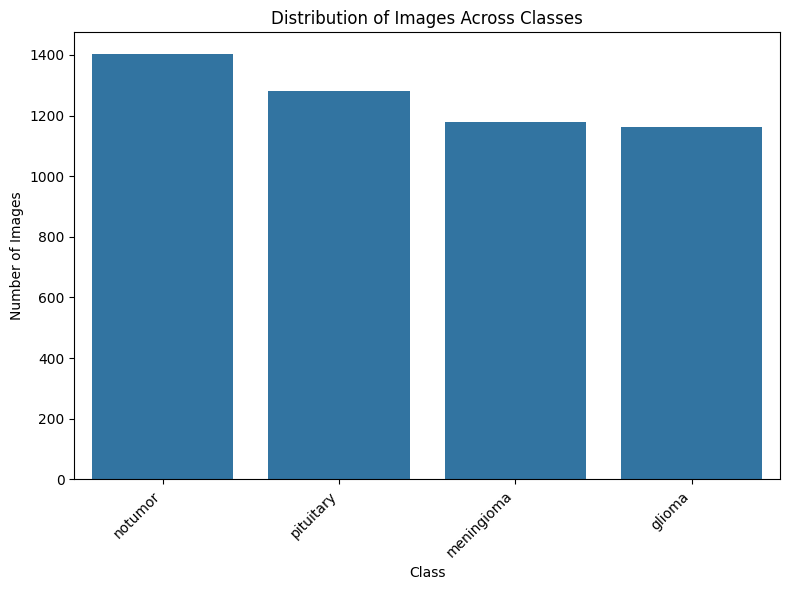

In [ ]:
# prompt: generate a bar chart how many images belong to each class

# Count images in each class
class_counts = train_df['labels'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


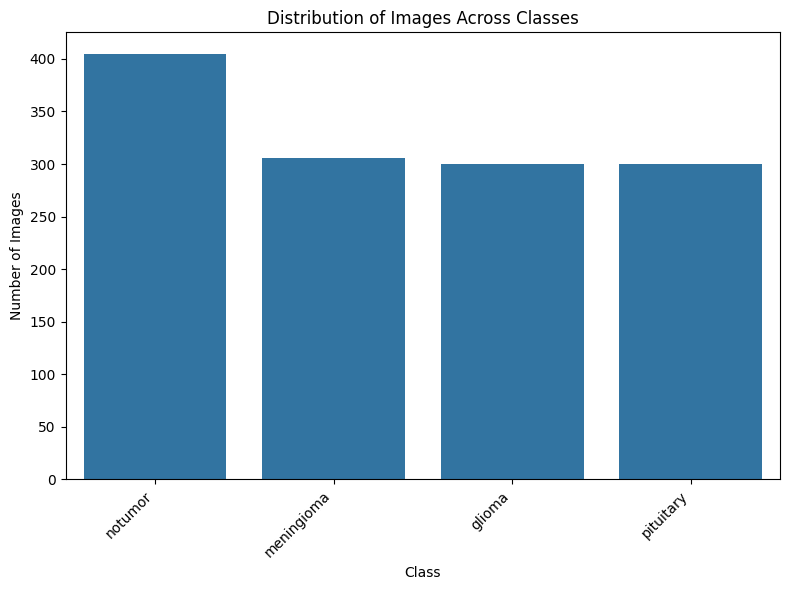

In [ ]:
# prompt: generate a bar chart how many images belong to each class

# Count images in each class
class_counts = test_df['labels'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


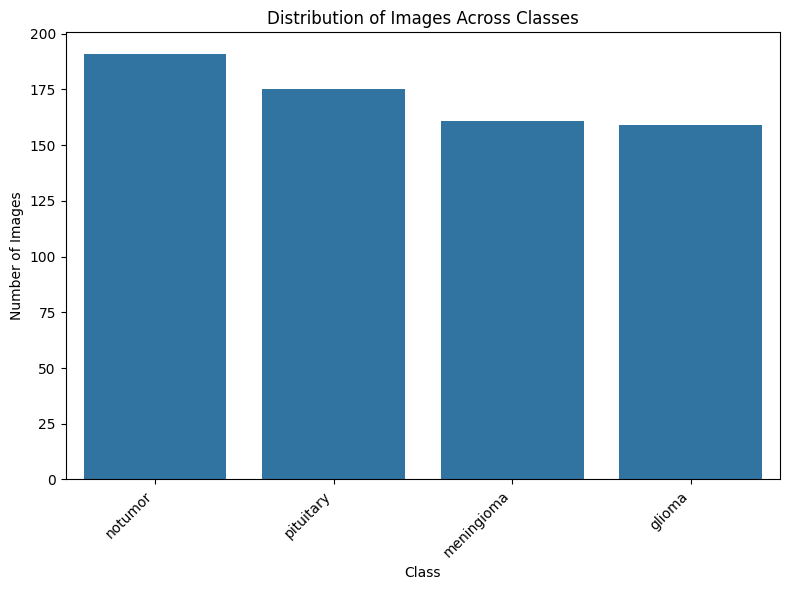

In [ ]:
# prompt: generate a bar chart how many images belong to each class

# Count images in each class
class_counts = valid_df['labels'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


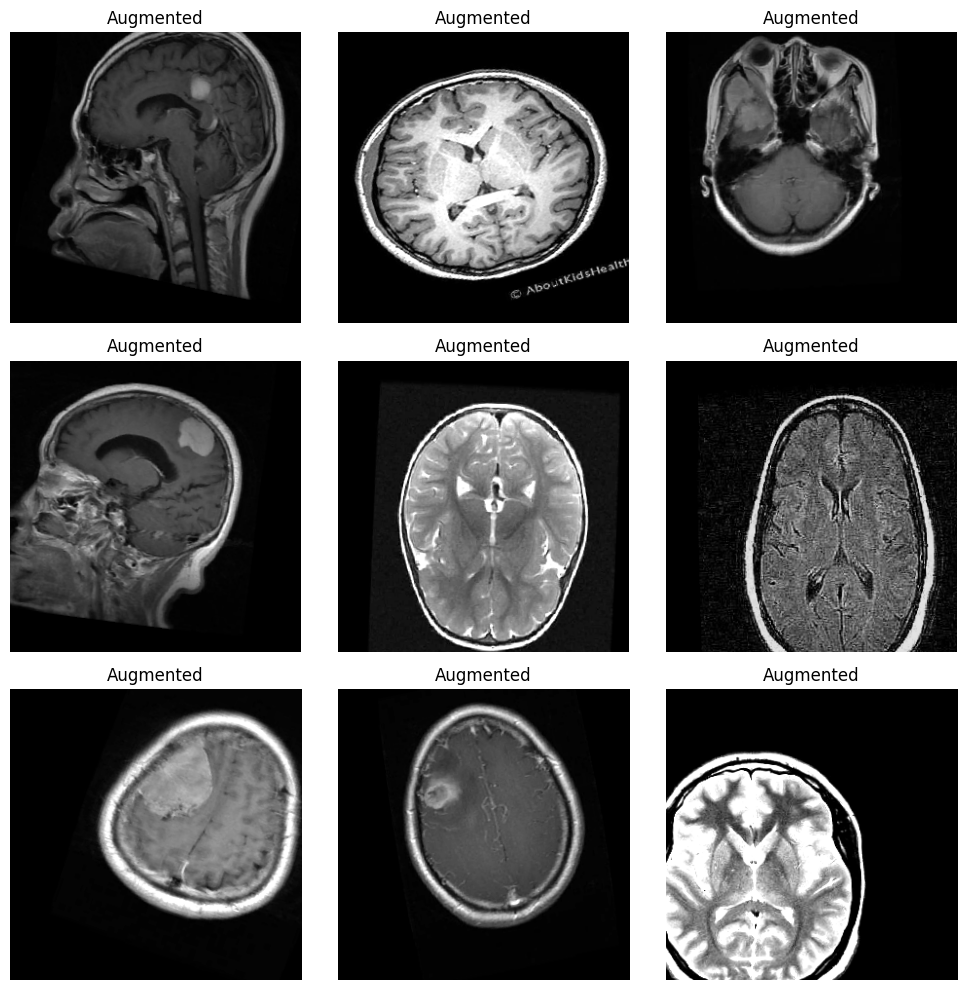

In [ ]:
# prompt: 3 x 3 grid to see the original and then the augmented image version with labels

# Display a 3x3 grid with original and augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    # Generate a batch of augmented images
    batch = train_gen.__next__() # Use __next__() instead of .next()
    image = batch[0][0]  # Take the first image from the batch

    # Original Image
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install keras
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Make sure to import the ImageDataGenerator class


In [ ]:
from keras.applications.inception_v3 import InceptionV3 # Import the InceptionV3 class


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
from tensorflow.keras.layers import BatchNormalization, Flatten, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Attention, Reshape
from tensorflow.keras import regularizers  # Import regularizers




In [ ]:

from tensorflow.keras.callbacks import TensorBoard
import os
from datetime import datetime

# Define the log directory where the logs will be saved
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
from keras.applications import InceptionV3
from keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [ ]:
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Added larger Dense layer
#     Dropout(0.5),  # Dropout for the added layer
#     Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),   # Original Dense layer
#     Dropout(0.4),  # Slightly reduced dropout
#     Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),   # Original Dense layer
#     Dropout(0.4),  # Slightly reduced dropout
#     Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),   # Added another Dense layer
#     Dropout(0.3),  # Dropout for the added layer
#     Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),    # Added another Dense layer
#     Dropout(0.3),  # Dropout for the added layer
#     Dense(4, activation='softmax')  # Output layer
# ])


In [ ]:
# prompt: import AveragePooling2D

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add


a try from chat

In [ ]:
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
# from tensorflow.keras import regularizers
# import numpy as np

# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

# # Custom head with Batch Normalization and additional layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)  # Added Batch Normalization for better convergence
# x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
# x = Dropout(0.35)(x)
# x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)  # Additional Dense and Dropout
# x = Dropout(0.5)(x)
# x = Dense(4, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=x)

# # Improved layer unfreezing strategy
# for layer in base_model.layers[:50]:
#     layer.trainable = False
# for layer in base_model.layers[50:]:
#     layer.trainable = True

#     ##130 layers gave 99.13 val but val loss was lower than test loss and loss was around.13 idk
#     # 100 layers never got past 98.98but loss got down to .012
## best results as is but takes 40 epochs to run gets to the max around 22 or so- reduce patience on early stopping next time run
# # Callbacks with more aggressive monitoring
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

# # Optimizer with AMSGrad variant for potentially better convergence
# optimizer = Adam(learning_rate=1e-4, amsgrad=True)

# # Compile the model
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# # Train the model with the perfect setup
# history = model.fit(
#     train_gen,
#     epochs=200,
#     validation_data=valid_gen,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )


In [ ]:
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras import regularizers

# # Base model
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

# # Custom head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Flatten spatial dimensions
# x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Reduced L2 regularization
# x = Dropout(0.54)(x)
# x = Dense(4, activation='softmax')(x)  # Final classification layer

# model = Model(inputs=base_model.input, outputs=x)

# # Freeze the first 150 layers and unfreeze the rest
# for layer in model.layers[:140]:
#     layer.trainable = False
# for layer in model.layers[140:]:
#     layer.trainable = True

# # Callbacks
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# # Optimizer with a lower learning rate
# optimizer = Adam(learning_rate=1e-4)

# # Compile the model
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# # Train the model
# history = model.fit(
#     train_gen,
#     epochs=200,
#     validation_data=valid_gen,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )


In [ ]:
# # Example adjustments to your model
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

# # Adjusted L2 regularization and Dropout rates
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)  # Lower L2
# x = Dropout(0.3)(x)  # Adjusted Dropout
# x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
# x = Dropout(0.4)(x)  # Adjusted Dropout
# x = Dense(4, activation='softmax')(x)

# # Improved layer unfreezing strategy
# for layer in base_model.layers[:140]:  # Adjust the number of layers to unfreeze
#     layer.trainable = False
# for layer in base_model.layers[140:]:
#     layer.trainable = True
# model = Model(inputs=base_model.input, outputs=x)
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# # Adjusted optimizer with a lower initial learning rate
# optimizer = Adam(learning_rate=3e-5, amsgrad=True)

# # Compile the model with the adjusted optimizer
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# # Train the model with the modified setup
# history = model.fit(
#     train_gen,
#     epochs=200,
#     validation_data=valid_gen,
#     callbacks=[early_stopping, reduce_lr, model_checkpoint]
# )


# #Epoch 18: val_accuracy did not improve from 0.99125
# # 315/315 ━━━━━━━━━━━━━━━━━━━━ 101s 315ms/step - AUC: 0.9998 - Precision: 0.9913 - Recall: 0.9908 - accuracy: 0.9912 - loss: 0.3741 - val_AUC: 0.9989 - val_Precision: 0.9840 - val_Recall: 0.9840 - val_accuracy: 0.9840 - val_loss: 0.3946 - learning_rate: 6.0000e-06
# # Epoch 19/200
# # 314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - AUC: 0.9999 - Precision: 0.9938 - Recall: 0.9925 - accuracy: 0.9929 - loss: 0.3701
# # Epoch 19: val_accuracy did not improve from 0.99125
# # 315/315 ━━━━━━━━━━━━━━━━━━━━ 102s 316ms/step - AUC: 0.9999 - Precision: 0.9938 - Recall: 0.9924 - accuracy: 0.9929 - loss: 0.3701 - val_AUC: 0.9989 - val_Precision: 0.9840 - val_Recall: 0.9840 - val_accuracy: 0.9840 - val_loss: 0.3923 - learning_rate: 1.2000e-06
# # Epoch 19: early stopping
# # Restoring model weights from the end of the best epoch: 16.

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

# Custom head with adjusted layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='linear', kernel_regularizer=regularizers.l2(0.0001))(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)  # Adjusted Dropout
x = Dense(64, activation='linear', kernel_regularizer=regularizers.l2(0.0001))(x)  # Added complexity
x = LeakyReLU()(x)
x = Dropout(0.3)(x)  # Adjusted Dropout
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze fewer layers initially
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Optimizer with a lower initial learning rate and AMSGrad
optimizer = Adam(learning_rate=3e-5, amsgrad=True)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Implementing callbacks
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# Train the model with the improved setup
history = model.fit(train_gen, epochs=200, validation_data=valid_gen, callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - AUC: 0.8532 - Precision: 0.6698 - Recall: 0.6059 - accuracy: 0.6422 - loss: 1.0644
Epoch 1: val_accuracy improved from -inf to 0.92128, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 219s 478ms/step - AUC: 0.8535 - Precision: 0.6702 - Recall: 0.6063 - accuracy: 0.6425 - loss: 1.0634 - val_AUC: 0.9890 - val_Precision: 0.9356 - val_Recall: 0.9111 - val_accuracy: 0.9213 - val_loss: 0.2580 - learning_rate: 3.0000e-05
Epoch 2/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - AUC: 0.9770 - Precision: 0.8770 - Recall: 0.8570 - accuracy: 0.8666 - loss: 0.4027
Epoch 2: val_accuracy improved from 0.92128 to 0.94023, saving model to best_model.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 104s 324ms/step - AUC: 0.9770 - Precision: 0.8770 - Recall: 0.8571 - accuracy: 0.8666 - loss: 0.4026 - val_AUC: 0.9945 - val_Precision: 0.9483 - val_Recall: 0.9359 - val_accuracy: 0.9402 - val_loss: 0.1884 - learning_rate: 3.0000e-05
Epoch 3/200
315/315 ━━━━━━━━━━━

<ipython-input-34-bf133cc85885>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


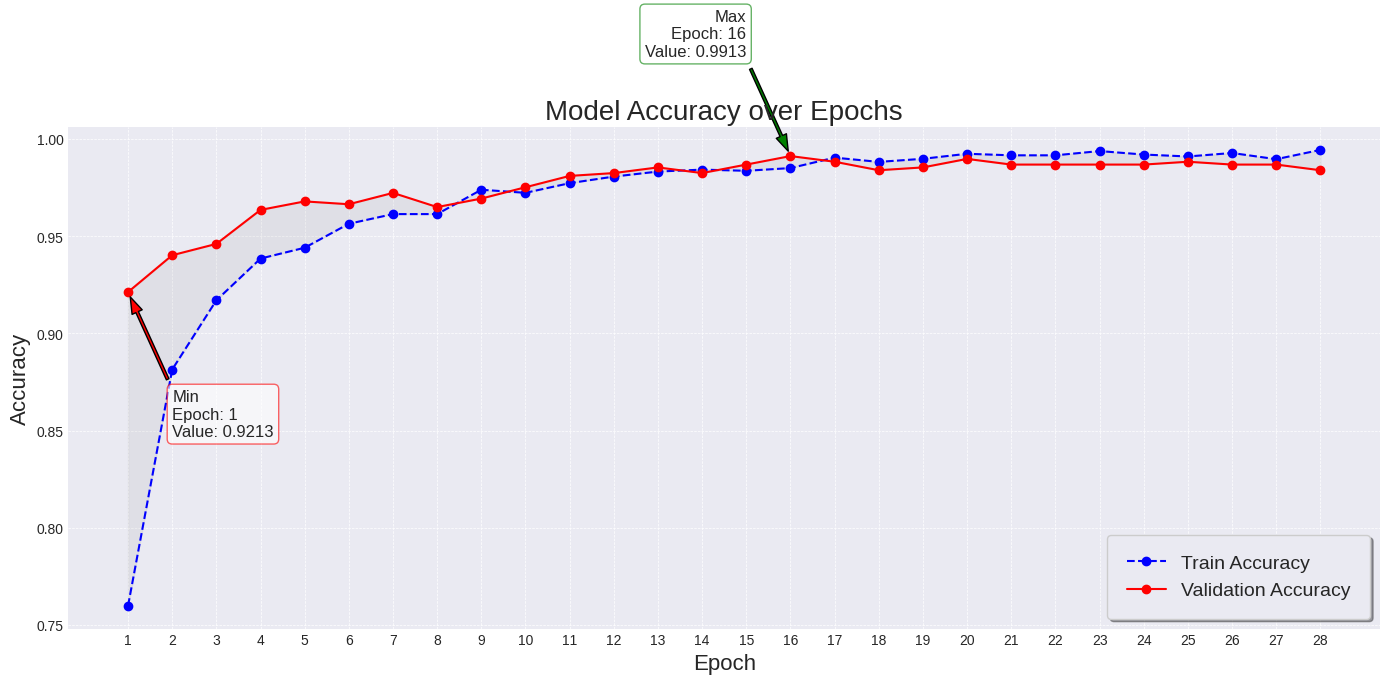

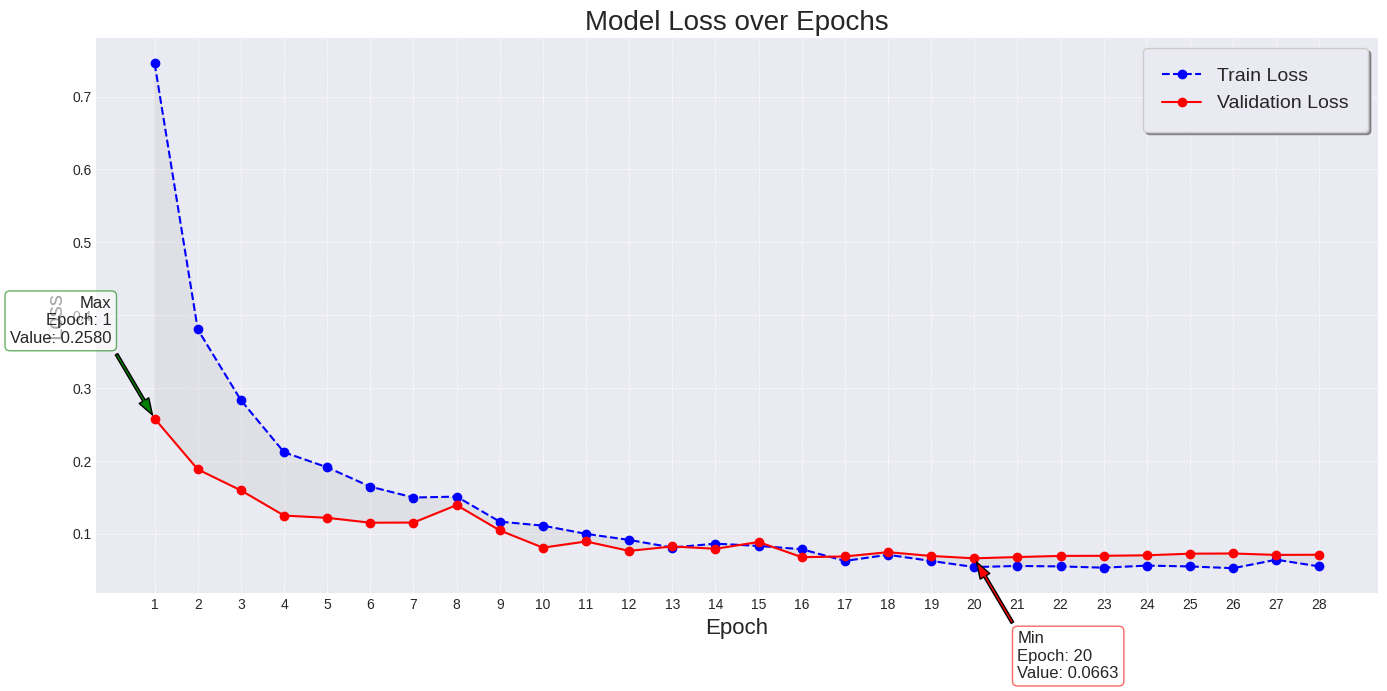

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the history from the model
history = model.history.history

# Extracting values for easier manipulation
epochs = range(1, len(history['accuracy']) + 1)
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Function to annotate the highest and lowest points
def annotate_min_max(x, y, ax=None, offset=0.05, fontsize=12):
    xmin = np.argmin(y)
    xmax = np.argmax(y)
    ymin = y[xmin]
    ymax = y[xmax]
    ax.annotate(f"Min\nEpoch: {x[xmin]}\nValue: {ymin:.4f}",
                xy=(x[xmin], ymin), xytext=(x[xmin] + 1, ymin - offset),
                arrowprops=dict(facecolor='red', shrink=0.05, headwidth=8, width=2),
                horizontalalignment='left', verticalalignment='top', fontsize=fontsize,
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white', alpha=0.6))
    ax.annotate(f"Max\nEpoch: {x[xmax]}\nValue: {ymax:.4f}",
                xy=(x[xmax], ymax), xytext=(x[xmax] - 1, ymax + offset),
                arrowprops=dict(facecolor='green', shrink=0.05, headwidth=8, width=2),
                horizontalalignment='right', verticalalignment='bottom', fontsize=fontsize,
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='green', facecolor='white', alpha=0.6))

# Customizing the style
plt.style.use('seaborn-darkgrid')

# Plotting training & validation accuracy values
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='--', color='b')
ax.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-', color='r')
ax.fill_between(epochs, train_acc, val_acc, color='gray', alpha=0.1)
ax.set_title('Model Accuracy over Epochs', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_xticks(epochs)
ax.legend(loc='lower right', fontsize=14, frameon=True, shadow=True, borderpad=1)
ax.grid(True, linestyle='--', linewidth=0.5)
annotate_min_max(epochs, val_acc, ax, offset=0.05, fontsize=12)
plt.tight_layout()
plt.show()

# Plotting training & validation loss values
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='--', color='b')
ax.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-', color='r')
ax.fill_between(epochs, train_loss, val_loss, color='gray', alpha=0.1)
ax.set_title('Model Loss over Epochs', fontsize=20)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_xticks(epochs)
ax.legend(loc='upper right', fontsize=14, frameon=True, shadow=True, borderpad=1)
ax.grid(True, linestyle='--', linewidth=0.5)
annotate_min_max(epochs, val_loss, ax, offset=0.1, fontsize=12)
plt.tight_layout()
plt.show()


<ipython-input-35-1f90365aacc6>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


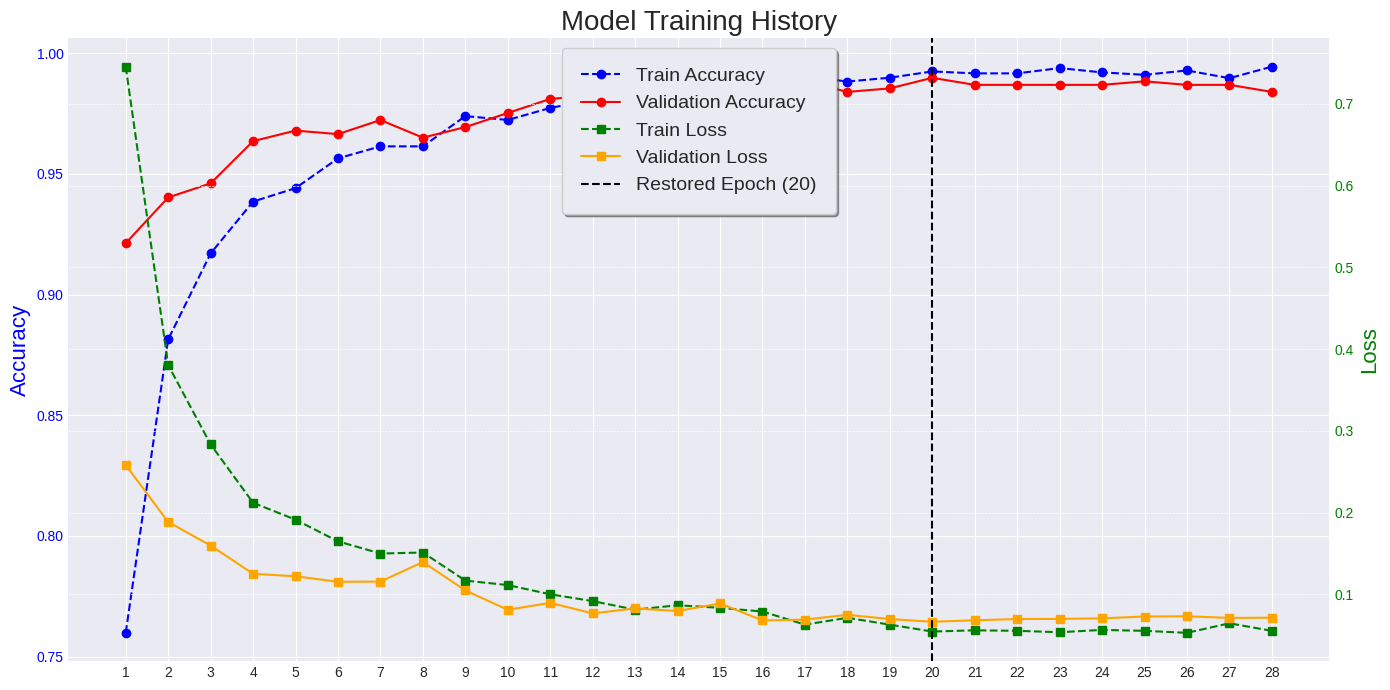

In [ ]:
# prompt: plot val and train accuracy , and val and train loss in the same graph, have a line that indicates which epoch was restored to at the end

# Retrieve the history from the model
history = model.history.history

# Extracting values for easier manipulation
epochs = range(1, len(history['accuracy']) + 1)
train_acc = history['accuracy']
val_acc = history['val_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']

# Find the epoch with the best validation loss (assuming EarlyStopping restored to this)
best_epoch = np.argmin(val_loss) + 1

# Customizing the style
plt.style.use('seaborn-darkgrid')

# Plotting training & validation accuracy and loss values in the same graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Accuracy (left y-axis)
ax1.plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='--', color='b')
ax1.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-', color='r')
ax1.set_ylabel('Accuracy', fontsize=16, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Loss (right y-axis)
ax2 = ax1.twinx()
ax2.plot(epochs, train_loss, label='Train Loss', marker='s', linestyle='--', color='g')
ax2.plot(epochs, val_loss, label='Validation Loss', marker='s', linestyle='-', color='orange')
ax2.set_ylabel('Loss', fontsize=16, color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and other settings
plt.title('Model Training History', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.xticks(epochs)
plt.grid(True, linestyle='--', linewidth=0.5)

# Line indicating the restored epoch
plt.axvline(x=best_epoch, color='k', linestyle='--', label=f'Restored Epoch ({best_epoch})')

# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=14, frameon=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step


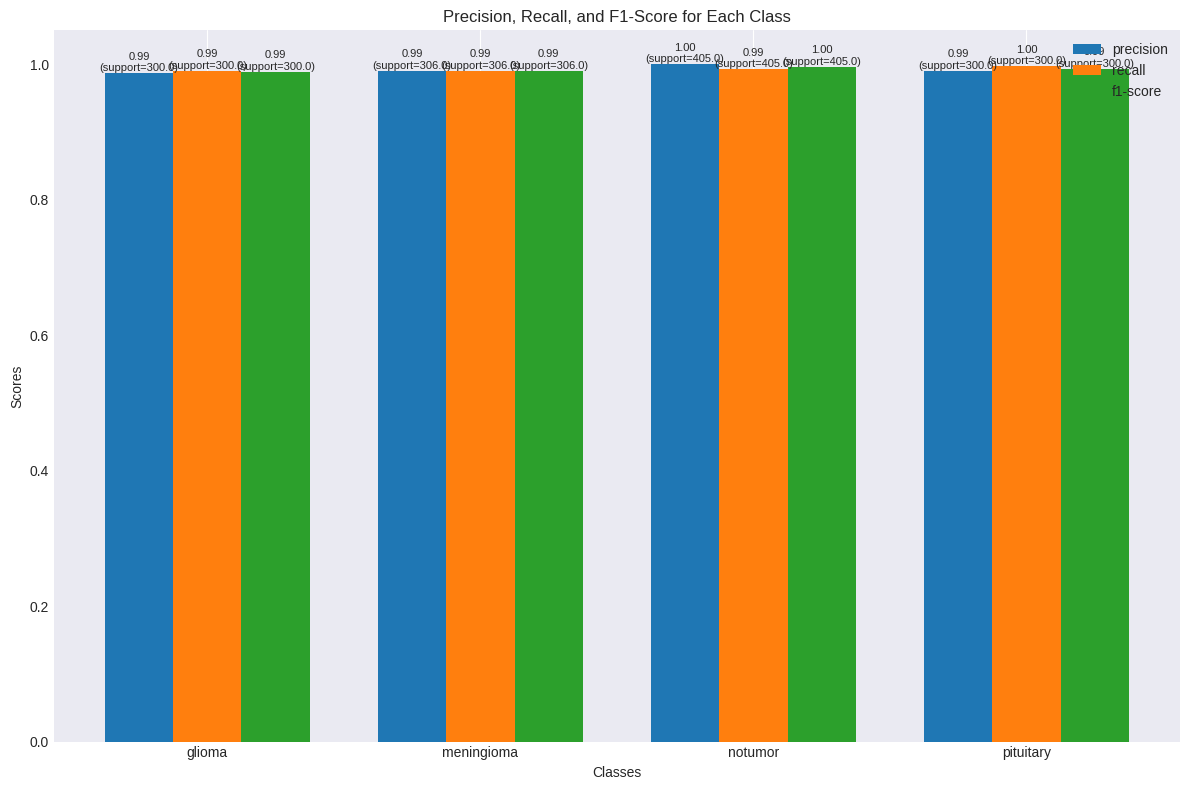

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual predictions and labels
y_true = test_gen.classes
y_pred = model.predict(test_gen).argmax(axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score']
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.25
index = np.arange(len(classes))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = [report[c][metric] for c in classes]
    ax.bar(index + i * bar_width, values, bar_width, label=metric)

# Plot support as an additional annotation
supports = [report[c]['support'] for c in classes]
for i, (rect, support) in enumerate(zip(ax.patches, supports * len(metrics))):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f'{height:.2f}\n(support={support})',
        ha='center',
        va='bottom',
        fontsize=8
    )

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for Each Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

# Display plot
plt.tight_layout()
plt.grid(axis='y')
plt.show()


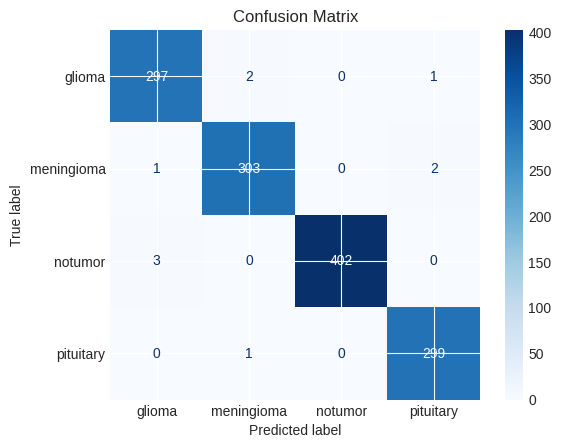

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_gen.class_indices)

# Display confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curve calculation
y_true_bin = label_binarize(y_true, classes=np.arange(len(test_gen.class_indices)))
y_pred_prob = model.predict(test_gen)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_gen.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, label in enumerate(test_gen.class_indices):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(len(test_gen.class_indices)):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i, label in enumerate(test_gen.class_indices):
    plt.plot(recall[i], precision[i], label=f'{label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Convert classification report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)


              precision    recall  f1-score      support
glioma         0.986711  0.990000  0.988353   300.000000
meningioma     0.990196  0.990196  0.990196   306.000000
notumor        1.000000  0.992593  0.996283   405.000000
pituitary      0.990066  0.996667  0.993355   300.000000
accuracy       0.992372  0.992372  0.992372     0.992372
macro avg      0.991743  0.992364  0.992047  1311.000000
weighted avg   0.992398  0.992372  0.992377  1311.000000


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming 'y_true' and 'y_pred' are your true and predicted labels
report = classification_report(y_true, y_pred, output_dict=True)  # Generate the report as a dictionary

# Convert classification report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score      support
0              0.986711  0.990000  0.988353   300.000000
1              0.990196  0.990196  0.990196   306.000000
2              1.000000  0.992593  0.996283   405.000000
3              0.990066  0.996667  0.993355   300.000000
accuracy       0.992372  0.992372  0.992372     0.992372
macro avg      0.991743  0.992364  0.992047  1311.000000
weighted avg   0.992398  0.992372  0.992377  1311.000000


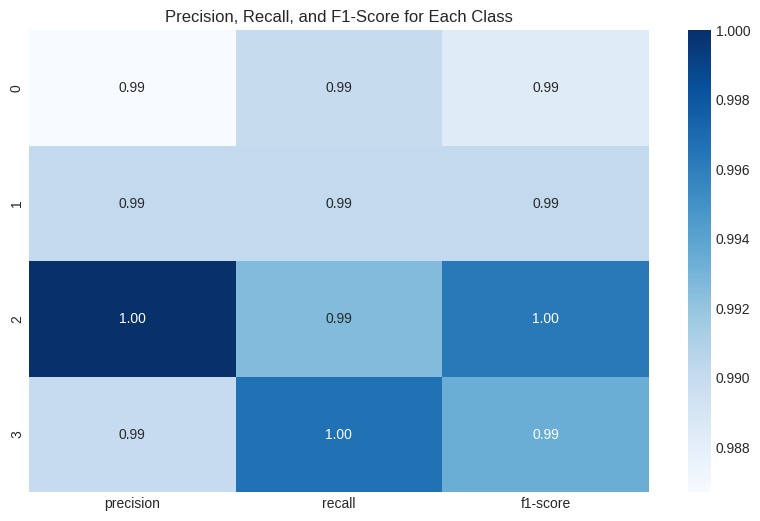

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'report_df' is your DataFrame from the previous step
metrics_df = report_df[['precision', 'recall', 'f1-score']].iloc[:-3]  # Extract metrics and exclude last 3 rows (accuracy, macro avg, weighted avg)
# metrics_df.index.name = 'Class'  # Set index name to 'Class'

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [ ]:
# prompt: test accuracy

# Evaluate the loaded model on the test data
test_accuracy = model.evaluate(test_gen)
print(test_accuracy)
# loss val, accuracy, precision, recall, QUC



82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - AUC: 0.9982 - Precision: 0.9918 - Recall: 0.9900 - accuracy: 0.9900 - loss: 0.0621
[0.0570957288146019, 0.9923722147941589, 0.9931297898292542, 0.9923722147941589, 0.9989275336265564]


In [ ]:
print(test_accuracy)
# loss val, accuracy, precision, recall, QUC


[0.0570957288146019, 0.9923722147941589, 0.9931297898292542, 0.9923722147941589, 0.9989275336265564]


In [ ]:
print( model.evaluate(train_gen))

print( model.evaluate(valid_gen))


315/315 ━━━━━━━━━━━━━━━━━━━━ 106s 336ms/step - AUC: 1.0000 - Precision: 0.9996 - Recall: 0.9992 - accuracy: 0.9996 - loss: 0.0341
[0.03415403887629509, 0.9994031190872192, 0.9994029998779297, 0.999204158782959, 0.9999996423721313]
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - AUC: 0.9979 - Precision: 0.9933 - Recall: 0.9926 - accuracy: 0.9926 - loss: 0.0699
[0.06635167449712753, 0.9897959232330322, 0.9912408590316772, 0.9897959232330322, 0.9988827109336853]


In [ ]:
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

classifcation report that looks like confusion matrix but instead its with precision recall and f1 score and has the blue side bar and everything

In [51]:
# prompt: generate me metrics about my model that do not include the usual

# Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient (MCC):", mcc)

# Cohen's Kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

# Area Under the Precision-Recall Curve (AUPRC)
from sklearn.metrics import average_precision_score
auprc = dict()
for i in range(len(test_gen.class_indices)):
    auprc[i] = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    print(f"AUPRC for class {i}: {auprc[i]:.2f}")

# Log Loss
from sklearn.metrics import log_loss
logloss = log_loss(y_true, y_pred_prob)
print("Log Loss:", logloss)

# Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print("Balanced Accuracy:", balanced_acc)
from sklearn.metrics import top_k_accuracy_score # Import the missing function

# Top-k Accuracy (e.g., Top-3)
top3_acc = top_k_accuracy_score(y_true, y_pred_prob, k=3)
print("Top-3 Accuracy:", top3_acc)


Matthews Correlation Coefficient (MCC): 0.9897742386560028
Cohen's Kappa: 0.9897688030436055
AUPRC for class 0: 1.00
AUPRC for class 1: 1.00
AUPRC for class 2: 1.00
AUPRC for class 3: 1.00
Log Loss: 0.024769108198664652
Balanced Accuracy: 0.992363834422658
Top-3 Accuracy: 1.0


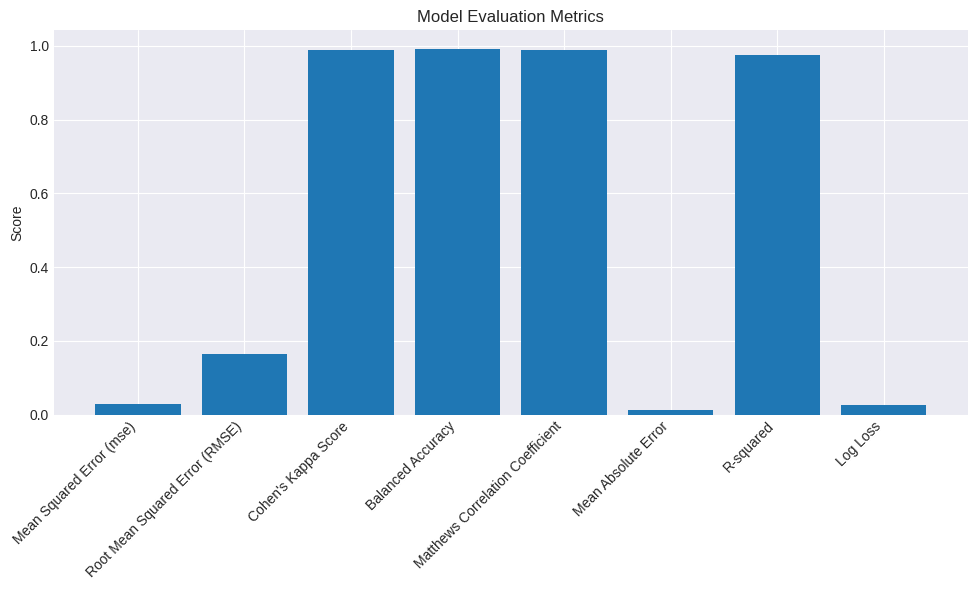

In [52]:
# prompt: make a chart where the y axis is mse, rmse,cohens kapa score, balanced accuracy, matthews correlation coeeficient, and 3 other metrics of evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have y_true and y_pred defined...

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
cohens_kappa = cohen_kappa_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
mean_absolute_error = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
log_loss_value = log_loss(y_true, y_pred_prob)  # Assuming y_pred_prob is available

# Create a dictionary for the metrics
metrics_dict = {
    'Mean Squared Error (mse)': mse,
    'Root Mean Squared Error (RMSE)': rmse,
    "Cohen's Kappa Score": cohens_kappa,
    'Balanced Accuracy': balanced_accuracy,
    'Matthews Correlation Coefficient': matthews_corrcoef,
    'Mean Absolute Error': mean_absolute_error,
    'R-squared': r2,
    'Log Loss': log_loss_value
}

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics_dict.keys(), metrics_dict.values())
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


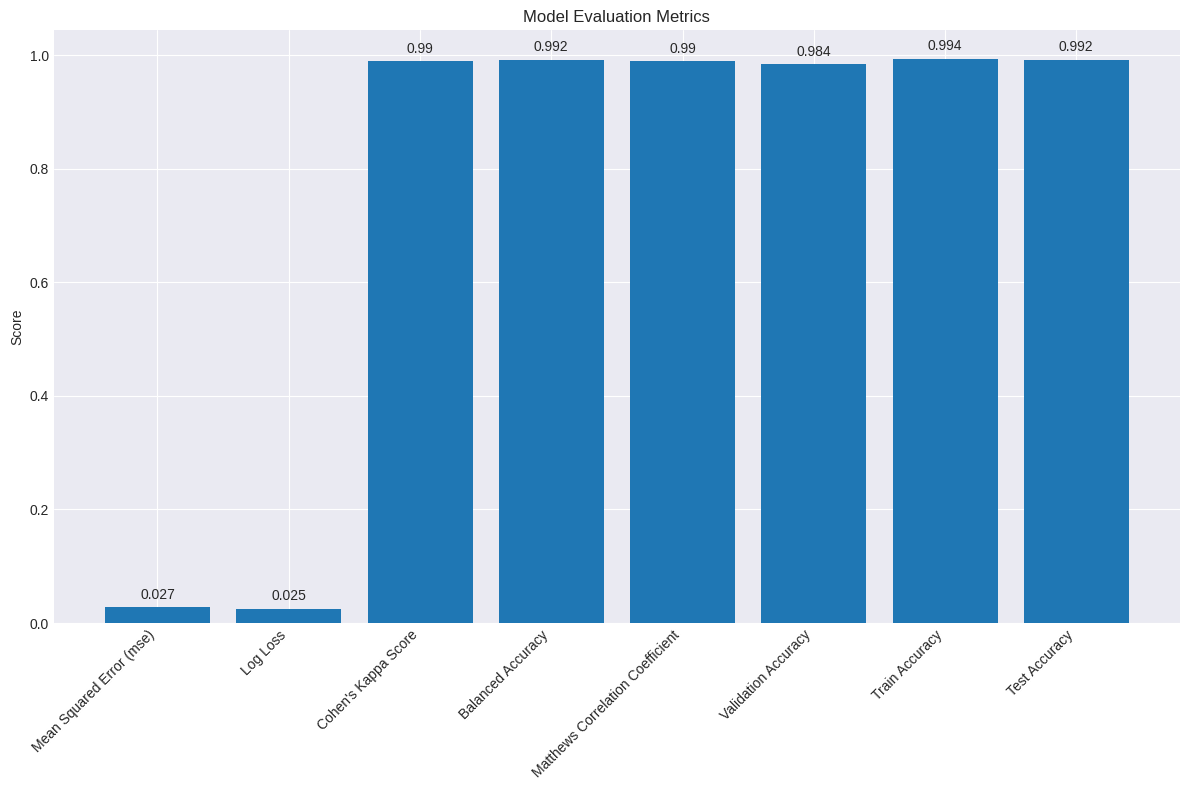

In [63]:
# prompt: # prompt: make a chart where the y axis is mse, rmse,cohens kapa score, balanced accuracy, matthews correlation coeeficient, validation accuracy, train accuracy, test accuracy
# include the number result for the class on top of the bar,

# Assuming you have calculated the following metrics:
# mse, rmse, cohens_kappa, balanced_accuracy, matthews_corrcoef, val_accuracy, train_accuracy, test_accuracy

# Create a dictionary for the metrics
metrics_dict = {
    'Mean Squared Error (mse)': mse,
    'Log Loss': logloss,
  "Cohen's Kappa Score": cohens_kappa,
    'Balanced Accuracy': balanced_accuracy,
    'Matthews Correlation Coefficient': matthews_corrcoef,
    'Validation Accuracy': val_accuracy,  # Assuming val_accuracy is a list [loss, accuracy]
    'Train Accuracy': train_accuracy,  # Assuming train_accuracy is a list of accuracies per epoch
    'Test Accuracy': test_accuracy  # Assuming test_accuracy is a list [loss, accuracy]
}

# Create a bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(metrics_dict.keys(), metrics_dict.values())
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks(rotation=45, ha='right')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
name of image  /content/Training/pituitary/Tr-piTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

  0%|          | 0/9998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [01:46, 106.24s/it]              


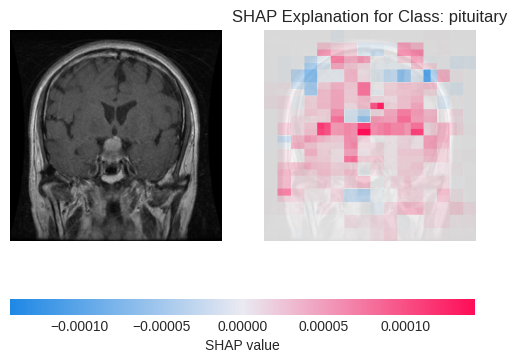

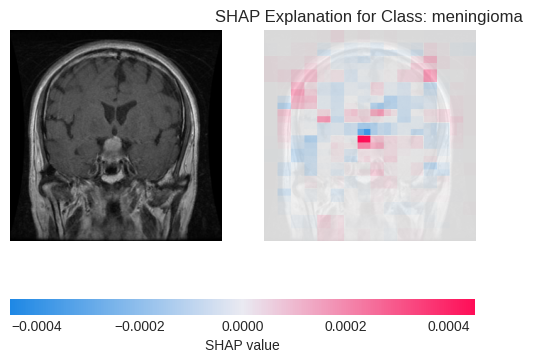

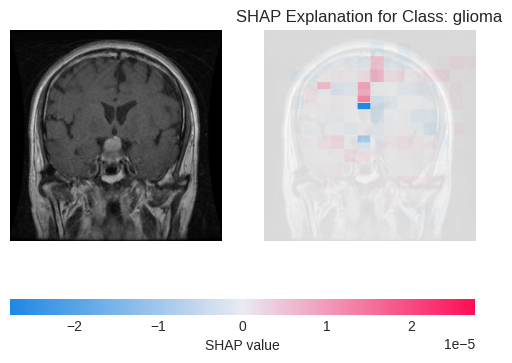

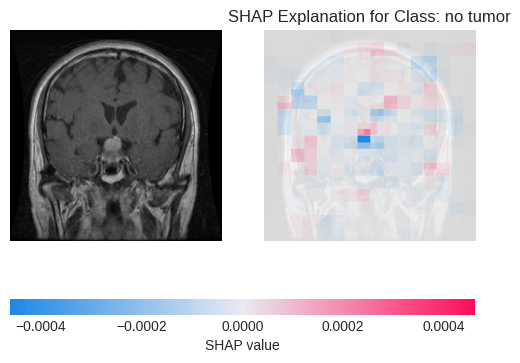

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
name of image  /content/Training/notumor/Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29

  0%|          | 0/9998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [01:45, 105.68s/it]              


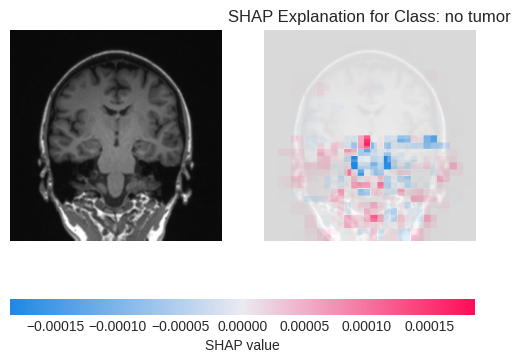

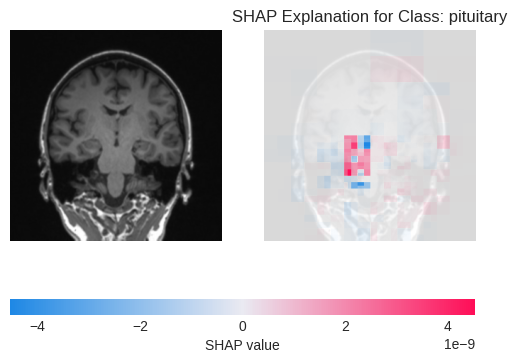

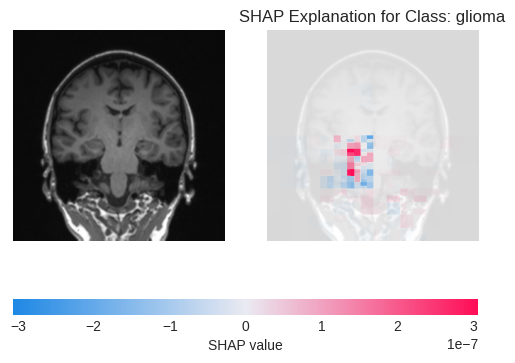

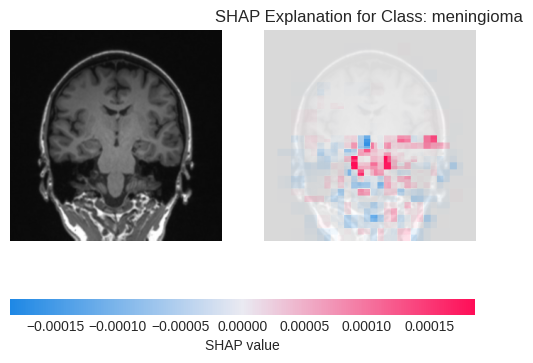

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
name of image  /content/Training/glioma/Tr-glTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31m

  0%|          | 0/9998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [01:46, 106.76s/it]              


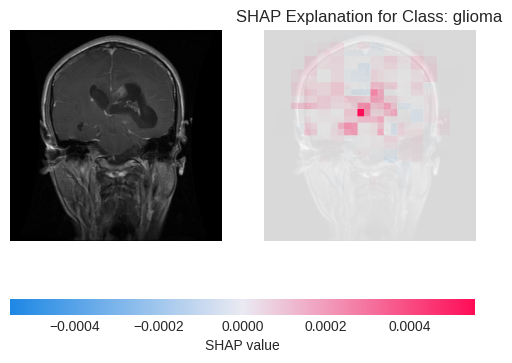

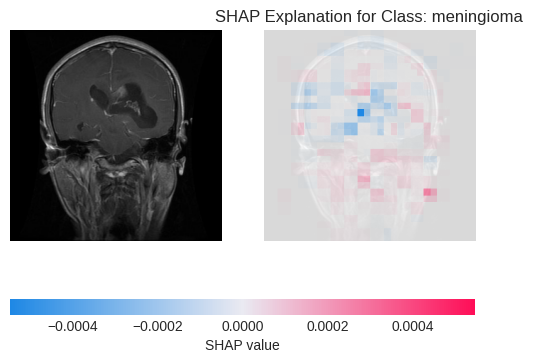

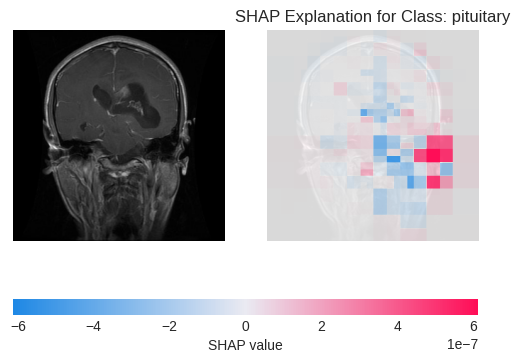

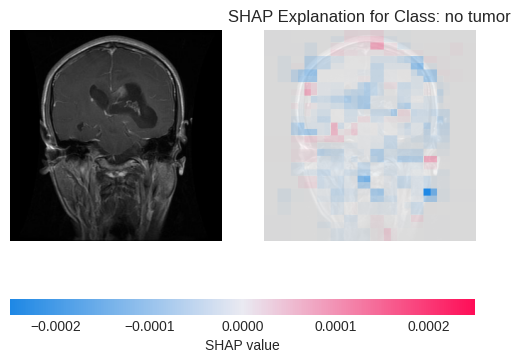

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
name of image  /content/Training/meningioma/Tr-me_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

  0%|          | 0/9998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [01:50, 110.77s/it]              


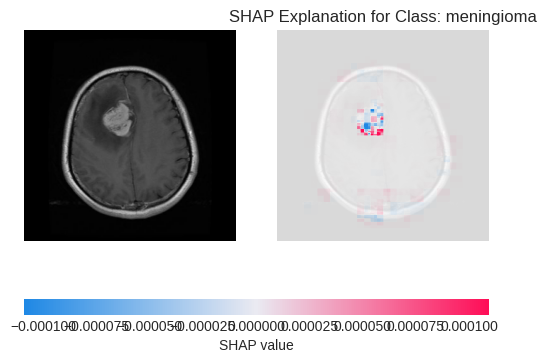

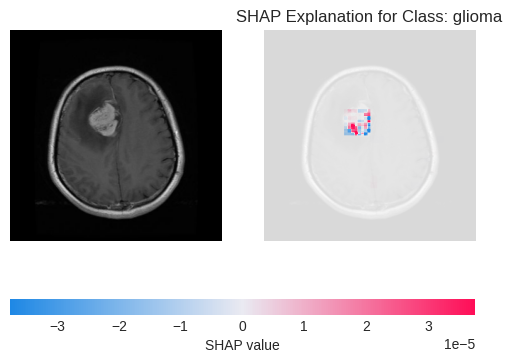

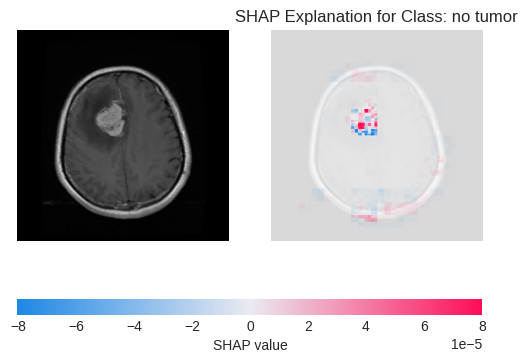

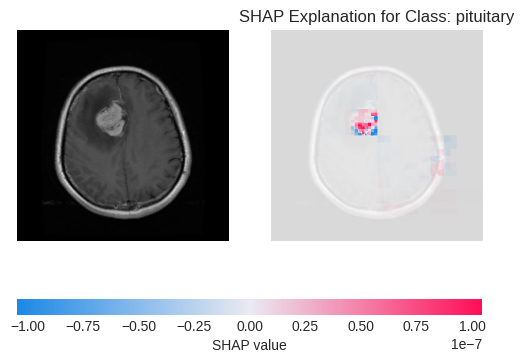

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
class_names = ["glioma", "meningioma", "no tumor", "pituitary"]

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

def explain_image_with_shap(image_path):
    """
    Explain the model's predictions on a given image using SHAP.

    Parameters:
    - image_path: Path to the input image.

    Returns:
    - None. Displays SHAP explanations.
    """
    # Preprocess the image
    def preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [299, 299])  # Resize image to (200, 200)
        image = tf.cast(image, tf.float32) / 255.0   # Normalize pixel values
        return image.numpy()

    image = preprocess_image(image_path)

    # Define the model prediction function for SHAP
    def f(x):
        return model.predict(x)

    # Create an Image masker for SHAP
    masker_blur = shap.maskers.Image("blur(20,20)", (299, 299, 3))

    # Create the SHAP explainer
    explainer_blur = shap.Explainer(f, masker_blur)

    # Predict the model's output for the input image
    predictions = model.predict(image[np.newaxis, :, :, :])
    # print("Predictions:", predictions)

    # Identify the top class index and corresponding class name
    top_class_index = np.argmax(predictions[0])
    top_class_name = class_names[top_class_index]
    top_class_probability = predictions[0][top_class_index]

    # print(f"Top class: {top_class_name} with probability {top_class_probability}")

    # Identify the top 4 class indices based on prediction probabilities
    top_4_indices = np.argsort(predictions[0])[::-1][:4]

    # print(f"Top 4 class indices: {top_4_indices}")
    # print(f"Top 4 class names: {[class_names[idx] for idx in top_4_indices]}")
    print("name of image ",image_path)

    # Calculate SHAP values for the top 4 classes
    shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=10000, outputs=top_4_indices)

    # Plot the SHAP values for the top 4 classes with labels
    for i, class_index in enumerate(top_4_indices):
        shap.image_plot([shap_values_fine.values[0][:, :, :, i]], image, show=False)
        plt.title(f"SHAP Explanation for Class: {class_names[class_index]}")
        plt.show()



pit1="/content/Training/pituitary/Tr-piTr_0004.jpg"
# pit2="/content/Training/pituitary/Tr-pi_0021.jpg"
explain_image_with_shap(pit1)
# explain_image_with_shap(pit2)
notum1="/content/Training/notumor/Tr-noTr_0004.jpg"
# notu2="/content/Training/notumor/Tr-no_0025.jpg"
explain_image_with_shap(notum1)
# explain_image_with_shap(notu2)
glioma1="/content/Training/glioma/Tr-glTr_0004.jpg"
# glioma2="/content/Training/glioma/Tr-gl_0011.jpg"
explain_image_with_shap(glioma1)
# explain_image_with_shap(glioma2)
men1="/content/Training/meningioma/Tr-me_0016.jpg"
explain_image_with_shap(men1)


# # Example usage:
# pitu1= "cancerbrain/pituitary/Tr-pi_0019.jpg"
# # pitu2= "cancerbrain/pituitary/Tr-pi_0020.jpg"
# # pitu3= "cancerbrain/pituitary/Tr-pi_0021.jpg"
# explain_image_with_shap(pitu1)
# # explain_image_with_shap(pitu2)
# # explain_image_with_shap(pitu3)


# notumor1= "/content/cancerbrain/notumor/Tr-noTr_0004.jpg"
# # notumor12= "/content/cancerbrain/notumor/Tr-noTr_0024.jpg"
# # notumor13= "/content/cancerbrain/notumor/Tr-noTr_0014.jpg"
# explain_image_with_shap(notumor1)
# # explain_image_with_shap(notumor12)
# # explain_image_with_shap(notumor13)

# men_1="/content/cancerbrain/meningioma/Tr-me_0068.jpg"
# # men_12="/content/cancerbrain/meningioma/Tr-me_0069.jpg"
# # men_13="/content/cancerbrain/meningioma/Tr-me_0098.jpg"
# explain_image_with_shap(men_1)
# # explain_image_with_shap(men_12)
# # explain_image_with_shap(men_13)




# gli_1="/content/cancerbrain/glioma/Tr-gl_0065.jpg"
# # gli_2="/content/cancerbrain/glioma/Tr-gl_0065.jpg"
# # gli_3="/content/cancerbrain/glioma/Tr-gl_0065.jpg"
# explain_image_with_shap(gli_1)
# # explain_image_with_shap(gli_2)
# # explain_image_with_shap(gli_3)



# testcase_lung=  "/content/000021_04_01_090.png"
# explain_image_with_shap(testcase_lung)

# normal_lung="/content/Normal case (1).jpg"
# normal_lung2="/content/Normal case (2).jpg"
# normal_lung3="/content/Normal case (3).jpg"
# normal_lung4= "/content/Normal case (5).jpg"
# normal_lung5= "/content/Normal case (6).jpg"
# normal_lung6= "/content/Normal case (7).jpg"


# explain_image_with_shap(normal_lung)
# explain_image_with_shap(normal_lung2)
# explain_image_with_shap(normal_lung3)
# explain_image_with_shap(normal_lung4)
# explain_image_with_shap(normal_lung5)
# explain_image_with_shap(normal_lung6)



# mal_lung="/content/Malignant case (1).jpg"
# mal_lung2="/content/Malignant case (2).jpg"
# mal_lung3="/content/Malignant case (3).jpg"
# mal_lung4= "/content/Malignant case (4).jpg"
# mal_lung5= "/content/Malignant case (5).jpg"
# mal_lung6= "/content/Malignant case (6).jpg"
# mal_lung7= "/content/Malignant case (7).jpg"
# explain_image_with_shap(mal_lung)
# explain_image_with_shap(mal_lung2)
# explain_image_with_shap(mal_lung3)
# explain_image_with_shap(mal_lung4)
# explain_image_with_shap(mal_lung5)
# explain_image_with_shap(mal_lung6)
# explain_image_with_shap(mal_lung7)


# benign_lung="/content/Bengin case (1).jpg"
# benign_lung2="/content/Bengin case (2).jpg"
# benign_lung3="/content/Bengin case (3).jpg"
# benign_lung4="/content/Bengin case (4).jpg"
# benign_lung5= "/content/Bengin case (5).jpg"
# benign_lung6= "/content/Bengin case (6).jpg"
# benign_lung7= "/content/Bengin case (7).jpg"


# explain_image_with_shap(benign_lung)
# explain_image_with_shap(benign_lung2)
# explain_image_with_shap(benign_lung3)
# explain_image_with_shap(benign_lung4)
# explain_image_with_shap(benign_lung5)
# explain_image_with_shap(benign_lung6)
# explain_image_with_shap(benign_lung7)






In [ ]:
# prompt: plot me an accyracy curve  where its labeled where overfitting and its ranging and  underfitting  and its range might curve the learning rates and early stopping be sure to indicate each

# Extracting values for easier manipulation
epochs = range(1, len(history['accuracy']) + 1)
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Customizing the style
plt.style.use('seaborn-darkgrid')

# Plotting training & validation accuracy values
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='--', color='b')
ax.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-', color='r')
ax.fill_between(epochs, train_acc, val_acc, color='gray', alpha=0.1)
ax.set_title('Model Accuracy over Epochs', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Epoch', fontsize=16)
ax.set_xticks(epochs)
ax.legend(loc='lower right', fontsize=14, frameon=True, shadow=True, borderpad=1)
ax.grid(True, linestyle='--', linewidth=0.5)

# Identify potential overfitting and underfitting regions
# This is a simplified example and might need adjustments based on your specific data
overfitting_start = 10  # Example: Overfitting starts around epoch 10
underfitting_end = 5   # Example: Underfitting ends around epoch 5

# Annotate overfitting and underfitting regions
ax.axvspan(overfitting_start, epochs[-1], facecolor='red', alpha=0.2, label='Potential Overfitting')
ax.axvspan(0, underfitting_end, facecolor='yellow', alpha=0.2, label='Potential Underfitting')

# Indicate early stopping point (assuming it was used)
early_stopping_epoch = 15  # Replace with the actual epoch where early stopping occurred
ax.axvline(early_stopping_epoch, color='black', linestyle='--', label='Early Stopping')

plt.tight_layout()
plt.show()


mapping predictions over

In [ ]:
class_names = ["glioma", "meningioma", "no tumor", "pituitary"]

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

def explain_image_with_shap(image_path):
    """
    Explain the model's predictions on a given image using SHAP.

    Parameters:
    - image_path: Path to the input image.

    Returns:
    - None. Displays SHAP explanations.
    """
    # Preprocess the image
    def preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [300, 300])  # Resize image to (200, 200)
        image = tf.cast(image, tf.float32) / 255.0   # Normalize pixel values
        return image.numpy()

    image = preprocess_image(image_path)

    # Define the model prediction function for SHAP
    def f(x):
        return model.predict(x)

    # Create an Image masker for SHAP
    # masker_blur = shap.maskers.Image("blur(200,200)", (200, 200, 3))

    # Create the SHAP explainer
    # explainer_blur = shap.Explainer(f, masker_blur)

    # Predict the model's output for the input image
    predictions = model.predict(image[np.newaxis, :, :, :])
    # print("Predictions:", predictions)

    # Identify the top class index and corresponding class name
    top_class_index = np.argmax(predictions[0])
    top_class_name = class_names[top_class_index]
    top_class_probability = predictions[0][top_class_index]

    # print(f"Top class: {top_class_name} with probability {top_class_probability}")

    # Identify the top 4 class indices based on prediction probabilities
    top_4_indices = np.argsort(predictions[0])[::-1][:4]

    # print(f"Top 4 class indices: {top_4_indices}")
    # print(f"Top 4 class names: {[class_names[idx] for idx in top_4_indices]}")
    # print("name of image ",image_path)
    return predictions



In [ ]:
Benign_images="/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_images="/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
normal_images="/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
print(len(Benign_images))
print(len(malignant_images))
print(len(normal_images))
benign_images_result=[]
malignant_images_result=[]
normal_images_result=[]
for filename in os.listdir(normal_images):
        image_path = os.path.join(normal_images, filename) # Construct full image path
        result=explain_image_with_shap(image_path)
        normal_images_result.append(result)

for filename in os.listdir(malignant_images):
        image_path = os.path.join(malignant_images, filename) # Construct full image path
        result=explain_image_with_shap(image_path)
        malignant_images_result.append(result)

for filename in os.listdir(Benign_images):
        image_path = os
        result=explain_image_with_shap(image_path)
        benign_images_result.append(result)



In [ ]:
print(benign_images_result)

In [ ]:
# prompt: create a table chart with benign_images_result

import pandas as pd

# Assuming 'benign_images_result' is a list of prediction arrays,
# each array having probabilities for each class

# Extract class names (assuming they are available from your model)
class_names = ["glioma", "meningioma", "no tumor", "pituitary"]

# Create a list to store formatted results
formatted_results = []

# Iterate through the prediction results
for result in benign_images_result:
  # Get the index of the predicted class (highest probability)
  predicted_class_index = np.argmax(result)

  # Create a dictionary to store the result for this image
  image_result = {
      "Predicted Class": class_names[predicted_class_index]
  }

  # Add probabilities for each class
  for i, class_name in enumerate(class_names):
    image_result[class_name + " Probability"] = result[0][i]

  # Append the result for this image to the list
  formatted_results.append(image_result)

# Create a DataFrame from the formatted results
df = pd.DataFrame(formatted_results)

# Display the DataFrame as a table
df


In [ ]:
# prompt: create a table chart with benign_images_result

import pandas as pd

# Assuming 'benign_images_result' is a list of prediction arrays,
# each array having probabilities for each class

# Extract class names (assuming they are available from your model)
class_names = ["glioma", "meningioma", "no tumor", "pituitary"]

# Create a list to store formatted results
formatted_results = []

# Iterate through the prediction results
for result in malignant_images_result:
  # Get the index of the predicted class (highest probability)
  predicted_class_index = np.argmax(result)

  # Create a dictionary to store the result for this image
  image_result = {
      "Predicted Class": class_names[predicted_class_index]
  }

  # Add probabilities for each class
  for i, class_name in enumerate(class_names):
    image_result[class_name + " Probability"] = result[0][i]

  # Append the result for this image to the list
  formatted_results.append(image_result)

# Create a DataFrame from the formatted results
df = pd.DataFrame(formatted_results)

# Display the DataFrame as a table
df


In [ ]:
# prompt: create a table chart with benign_images_result

import pandas as pd

# Assuming 'benign_images_result' is a list of prediction arrays,
# each array having probabilities for each class

# Extract class names (assuming they are available from your model)
class_names = ["glioma", "meningioma", "no tumor", "pituitary"]

# Create a list to store formatted results
formatted_results = []

# Iterate through the prediction results
for result in normal_images_result:
  # Get the index of the predicted class (highest probability)
  predicted_class_index = np.argmax(result)

  # Create a dictionary to store the result for this image
  image_result = {
      "Predicted Class": class_names[predicted_class_index]
  }

  # Add probabilities for each class
  for i, class_name in enumerate(class_names):
    image_result[class_name + " Probability"] = result[0][i]

  # Append the result for this image to the list
  formatted_results.append(image_result)

# Create a DataFrame from the formatted results
df = pd.DataFrame(formatted_results)

# Display the DataFrame as a table
df
